# todos for l0 attack

create mask

call l2 adversary - get the adversarial immage

compute the gradient of the objective function with the adversarial

select pixels where gradient * delta is smallest


In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals
import numpy as np
import pandas as pd
import math
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from absl import app, flags
from easydict import EasyDict
from tensorflow.keras import Model
from tensorflow.keras.layers import AveragePooling2D, Dense, Flatten, Conv2D, MaxPool2D
import tensorflow_datasets as tfds
from tensorflow.keras import layers
from tqdm import tqdm
import matplotlib.pyplot as plt

from cleverhans.future.tf2.attacks import projected_gradient_descent, fast_gradient_method

import foolbox as fb
import eagerpy as ep
from foolbox import TensorFlowModel, accuracy, samples
import foolbox.attacks as fa
import numpy as np
np.set_printoptions(suppress=True)

In [3]:
model = tf.keras.models.load_model('../saved-models/attack-test-model')

In [3]:
fb.__version__

'3.0.0'

In [4]:
np.__version__

'1.18.4'

In [5]:
import numba as nb
nb.__version__

'0.49.1'

In [6]:
import eagerpy as ep
ep.__version__

'0.27.0'

### Start with definition and training of the DNN at the bottom of this NB

# C&W L2 Attack

$F(x) = y$  neural network<br>
$F$  model<br>
$x$  input<br>
$y$  output<br>
$m$  amount of classes<br>

$C(x)$  label assigned by model =arg max F(x)<br>
$C*(x)$  correct label<br>
$Z(x) = z$  logits -> output of all layers except softmax<br>

$F(x)$ = $softmax(Z(x))$ = $y$<br>
$F$ = $softmax ◦ F_n ◦ F_n-1 ◦ ... ◦ F_1$  A network consists of layers $F_n$<br>
$F_i(x)$ = $\sigma$ * $(\Theta_i * x)$ + $\hat{\Theta_i}$<br>
$\sigma$  activation function<br>
$\Theta$  Params<br>
$\hat{\Theta}$ Bias<br>

$t$  target class<br>
$x$  input<br>
$x'$ adversarial input <br>

$||x - x'||_p$ the $L_p$ distance
$|| · ||_p$  = $ || v ||_p = ( \sum_{n=1}^{n} | v_i | ^ p)^{1/p}$


# Approach
minimize $D (x, x + \delta)$ <br>
such that <br>
$C(x + \delta) = t$<br>
$x + \delta \in [0,1]$


$\delta$ change
$D$ distance metric

### Alternative Formulation
minimize $D (x, x + \delta) + c * f(x+\delta)$ <br>
such that <br>
$x + \delta \in [0,1]$

$f(x+\delta)$ is one of the following objective functions
$c$ is a constant

### Set norm as distance measure 

minimize $||\delta||_p + c * f(x+\delta)$ <br>
such that <br>
$x + \delta \in [0,1]$

# Objective Functions

$f_1(x) = -loss_{F,t}(x')+1$ <br>
$f_2(x) = (max(F(x')_i) - F(x')_t)^+$ <br>
$f_3(x) = softplus(max(F(x')_i) - F(x')_t) - log(2)$<br>
$f_4(x) = (0.5 - F(x')_t)^+$<br>
$f_5(x) = -log(2F(x')_t -2)$ <br>
$f_6(x) = (max(Z(x')_i) - Z(x')_t)^+$ <br>
$f_7(x) = softplus(max(Z(x')_i) - Z(x')_t) - log(2)$

$(yyy)^+ = max(yyy, o)$<br>
$softplus(yyy) = log(1+exp(yyy))$<br>
$loss_{F,t}(x)$ = cross entropy loss

## ensure box contraint
introduce an new variable $w$<br>
so<br>
$\delta_i = 1/2(tanh(w_i)+1)-x_i$

$x_i+ \delta_i \in [0,1]$ because:<br>
$-1 \leq tanh(x) \leq 1$<br>
so<br>
$0 \leq x_i+\delta_i \leq 1$

# Putting it together
###### for the l2 attack
f1 : minimize $||1/2(tanh(w_i)+1)-x_i||^2_2 +c * f(1/2(tanh(w)+1)$

with $f$ defined as:

f2 : $f(x') = $ max$($max$({Z(x')_i:i\neq t} )-Z(x')_t, -\kappa)$

# L0 Attack

In [4]:
#def find_adv_example_l0(x, model):


ITER = 70
adv_l0 = tf.Variable(initial_value=x)
mask = np.ones(x.shape)[0]

for i in range(ITER):

    success, adv_l0, grads, delta, w, last_successfull_adv = find_adv_example_l2(x, model,max_iterations=1000, mask=mask, verbose=False)
    plt.figure()
    plt.imshow(tf.reshape(x+delta, (28,28)))
    plt.show()
    #print('grads', grads)
    total_abs_change = tf.math.reduce_sum(tf.math.abs(delta), 0)*tf.math.abs(grads)[0]
    #print('total abs change',total_abs_change)
    count=0
    non_zero = np.count_nonzero(mask)
    for idx, j in enumerate(np.argsort(total_abs_change)):
        #print('idx',idx)
        #if total_abs_change[j] < .3 and mask[j] != 0:
        if mask[j] != 0:
            count += 1
            mask[j] = 0
        if count>0.2*non_zero: break
    if np.argmax(model(x+delta)[0])==7:
        i = ITER - 3
        print('mask non zeros',np.count_nonzero(mask))
        print(model(x + delta))
        print('________________no adv found_______________')
        if last_successfull_adv != None:
            print(model(last_successfull_adv))
            plt.figure()
            plt.imshow(tf.reshape(last_successfull_adv, (28,28)))
            plt.show()
            
        #break
    #print('count', count)
    #non_zero = np.count_nonzero(mask)
    print('mask non zeros',np.count_nonzero(mask))
    print(model(x + delta))
    if last_successfull_adv == None:
            break
    #return adv_l0, grads, delta, total_abs_change, mask

    
    
    

NameError: name 'x' is not defined

In [5]:
print('adv')
plt.figure()
plt.imshow(tf.reshape(adv_test, (28,28)))
plt.show()
print('ori')
plt.figure()
plt.imshow(tf.reshape(x, (28,28)))
plt.show()

adv


NameError: name 'adv_test' is not defined

<Figure size 432x288 with 0 Axes>

In [6]:
def loss_function(x, adv_image, const, target):
    l1 = tf.square(tf.norm(adv_image - x))
    logit_of_best_other = get_logit_of_best_except_target(model, adv_image, target)
    logit_of_target = get_logit_of_target(model, adv_image,target)
    l2 = const * tf.math.maximum(
        logit_of_best_other
        - logit_of_target
        , 0 )
    return l1 + l2
    
def alternate_loss_fn(x, adv_image, const, target):
    #print('adv',adv_x)
    #print('clean', x)
    #check why the do not use norm in the cleverhans implementation

    loss1 = tf.square(tf.norm(adv_image - x))
    #loss1 = tf.square(tf.norm(adv_image - x, ord=1))
    loss2 = const * f2(adv_image, target)
    #print('losses: ',loss1.numpy(), loss2.numpy())
    #print('loss:', (loss2 + loss1).numpy())
    return loss2 + loss1
    #return loss1 + loss2

In [7]:

def f2(adv_x, target):
    logit_of_best_other = get_logit_of_best_except_target(model, adv_x, target)
    logit_of_target = get_logit_of_target(model, adv_x, target)
    
    return tf.math.maximum(logit_of_best_other - logit_of_target, 0 )

    

In [8]:
test = tf.Variable(initial_value=[[1., 2.],[1., 1.]]) * tf.Variable(initial_value=tf.ones((2,2)))
np.argmax(test)

1

In [9]:

def find_adv_example_l2(x, model, max_iterations=1000, mask=tf.Variable(initial_value=tf.ones(x.shape)), verbose=True):

    w = tf.Variable(initial_value=tf.zeros(x.shape))

    optimizer = tf.keras.optimizers.Adam(.01)
    target = find_second_most_probable_class(get_logits(model,x))
    #target = 1
    l2_distance = 0
    dist_hist = []
    w_hist = []
    last_successfull_adv = None
    for i in range(max_iterations):
        if verbose: print(i)
        
        with tf.GradientTape() as tape:
            delta = ((.5 * (tf.tanh(w) + 1)) - x) * mask
            
            adv_image = x + delta_now 

            success = target == np.argmax(model(adv_image))

            const= .1
            loss = loss_function(x=x, adv_image=adv_image, const=const, target=target)

            l2_distance = tf.norm(adv_image - x).numpy()
            
            
            linf_distance = tf.norm(adv_image - x, ord=np.inf).numpy()
            l1_distance = tf.norm(adv_image - x, ord=1).numpy()
            grads = tape.gradient(loss, w)
            if success == True:
                last_successfull_adv = adv_image

            optimizer.apply_gradients([(grads, w)])
            w_hist.append(w)
            dist_hist.append(l2_distance)
            if i>2 and dist_hist[i] > dist_hist[i-3] and success == True:
                w = w_hist[i-3]
                delta = ((.5 * (tf.tanh(w) + 1)) - x) * mask
                adv_image = x + delta 
                print('early stop')
                return success, adv_image, grads, delta, w, last_successfull_adv#, dist_hist
            if i%10 == 0 and verbose:
                print('l2 dist:', l2_distance)
                print('l1 dist:', l1_distance)
                print('l_inf dist:', linf_distance)
                print('target class: ',target)
                print('pred of adv ex: ',np.argmax(model(adv_image)))
            
    return success, adv_image, grads, delta, w, last_successfull_adv


NameError: name 'x' is not defined

In [ ]:
MAX_ITERATIONS = 3000
adv,_,_, dist_hist= find_adv_example_l2(x, model, MAX_ITERATIONS)
plt.figure()
plt.imshow(tf.reshape(adv, (28,28)))
plt.show()
plt.figure()
plt.imshow(tf.reshape(x, (28,28)))
plt.show()

In [ ]:
print(dist_hist)
scale = [i for i in range(len(dist_hist))]
plt.plot(scale, dist_hist)
plt.show

In [ ]:
dist_hist_from_zero
print(np.min(dist_hist_from_zero))
print(np.min(dist_hist))

# Helper Functions for L2 Attack

In [10]:
def find_second_most_probable_class(logits):
    logits = logits.numpy().flatten()
    return np.argpartition(logits,len(logits)-2)[len(logits)-2]
        
def get_logits(model, x):
    model(x)
    return model.pre_softmax[0]
    
def get_least_probable(model, x):
    all_logits = get_logits(model, x)
    #print(all_logits)
    return tf.math.argmin(all_logits)


def get_logit_of_best_except_target(model, adv_x, target):
    all_logits = get_logits(model, adv_x)
    #print('all_logits', all_logits)
    most_probable_class = tf.math.argmax(all_logits)
    second_most_probable_class = find_second_most_probable_class(all_logits)
    if target == most_probable_class: 
        return all_logits[second_most_probable_class ]
    if target != most_probable_class: 
        return all_logits[most_probable_class ]

def get_logit_of_target(model, adv_x, target):
    all_logits = get_logits(model, adv_x)
    return all_logits[target]



In [11]:

w = tf.Variable(initial_value=tf.zeros(x.shape))
adv_x = .5*(tf.tanh(w) + 1)
#constant = 0
delta = (adv_x - x)
optimizer = tf.keras.optimizers.SGD()
optimizer.minimize(f1, var_list= [w])

NameError: name 'x' is not defined

# load imagenette data

In [12]:
ds = tfds.load(name="imagenette", with_info=True, split=["train","validation"])
ds_train=ds[0][0]
ds_test=ds[0][1]
assert isinstance(ds_train, tf.data.Dataset)

def normalize(x):
    y = {'image': tf.image.convert_image_dtype(x['image'], tf.float32), 'label': x['label']}
    y = (tf.image.resize(y['image'], (224,224)), y['label'])
    return y
    
ds_train = ds_train.map(lambda x: normalize(x))
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(100)
ds_train = ds_train.batch(8)
ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)

ds_test = ds_test.map(
    normalize, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_test = ds_test.batch(8)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.experimental.AUTOTUNE)

tf.Tensor(9, shape=(), dtype=int64)
(224, 224, 3)


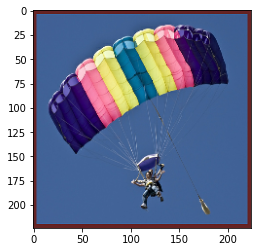

In [20]:
for z in ds_test.take(1):
    print(z[1][0])
    print(z[0][0].shape)
    x = z[0][0].numpy()
    tf.reshape
    plt.figure()
    plt.imshow(x)
    plt.show()

# Define and Train Model

## Definiton of MLP DNN

In [1]:
class CustomLayer(layers.Layer):

    def __init__(self, units=32, activation='relu', input_shape=(784)):
        super(CustomLayer, self).__init__()
        self.units = units
        self.activation = activation
        self.w = self.add_weight(shape=(input_shape[-1], self.units),
                                 initializer='random_normal',
                                 trainable=True,
                                name='weightss')
        self.mask = self.add_weight(shape=(self.w.shape),
                                    initializer='ones',
                                    trainable=False,
                                   name='masks')
        self.pruned_w = self.add_weight(shape=(input_shape[-1], self.units),
                                 initializer='ones',
                                 trainable=False,
                                       name='pruned-weightss')

   
    def call(self, inputs):
        self.pruned_w = tf.multiply(self.w, self.mask)
        x = tf.matmul(inputs, self.pruned_w)
        
        if self.activation == 'relu':
            return tf.keras.activations.relu(x)
        if self.activation == 'softmax':
            return tf.keras.activations.softmax(x)
        if self.activation == None:
            return x
            
        raise ValueError('Activation function not implemented')


class LeNet300_100(tf.keras.Model):
    def __init__(self):
        super(LeNet300_100, self).__init__()
        self.dense1 = CustomLayer(300, input_shape=(None, 784))
        self.dense2 = CustomLayer(100, input_shape=(None, 300))
        self.dense3 = CustomLayer(10, activation=None, input_shape=(None, 100))
        
    def call(self, inputs):
        #print('NN call',inputs.shape)
        x = tf.keras.layers.Flatten()(inputs)
        x = self.dense1(x)
        
        x = self.dense2(x)
        x = self.dense3(x)
        self.pre_softmax = x
        return tf.keras.activations.softmax(x)
        #return x
    


NameError: name 'layers' is not defined

In [13]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = (x_train.reshape(60000, 784).astype('float32') / 255)[:500]
y_train = y_train[:500]
x_test = (x_test.reshape(10000, 784).astype('float32') / 255)
x = tf.convert_to_tensor(tf.expand_dims(x_train[422], axis=0), tf.float32)

In [14]:
def ld_mnist():
    """Load training and test data."""

    def convert_types(image, label):
        image = tf.cast(image, tf.float32)
        image /= 255
        return image, label

    dataset, info = tfds.load('mnist', 
                              data_dir='gs://tfds-data/datasets', 
                              with_info=True,
                              as_supervised=True)
    mnist_train, mnist_test = dataset['train'], dataset['test']
    mnist_train = mnist_train.map(convert_types).shuffle(10000).batch(128)
    mnist_test = mnist_test.map(convert_types).batch(128)
    return EasyDict(train=mnist_train, test=mnist_test)
data = ld_mnist()

In [15]:
def initialize_model():
    model = LeNet300_100()
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) ,
                  metrics=['accuracy'],
                  experimental_run_tf_function=False
                 )
    return model

def train_model(model):
    callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
    model.fit(x=data.train,
              #batch_size=64,
              epochs=500,
              callbacks=[callback],
              validation_data=(x_test, y_test),
             )


In [11]:
model = initialize_model()
train_model(model)

Epoch 1/500
469/469 [==============================] - 8s 18ms/step - loss: 1.6691 - accuracy: 0.8126 - val_loss: 1.6112 - val_accuracy: 0.8514
Epoch 2/500
469/469 [==============================] - 6s 13ms/step - loss: 1.6034 - accuracy: 0.8594 - val_loss: 1.5957 - val_accuracy: 0.8657
Epoch 3/500
469/469 [==============================] - 6s 13ms/step - loss: 1.5654 - accuracy: 0.8982 - val_loss: 1.5073 - val_accuracy: 0.9566
Epoch 4/500
469/469 [==============================] - 6s 13ms/step - loss: 1.4988 - accuracy: 0.9652 - val_loss: 1.4994 - val_accuracy: 0.9638
Epoch 5/500
469/469 [==============================] - 8s 17ms/step - loss: 1.4901 - accuracy: 0.9733 - val_loss: 1.4929 - val_accuracy: 0.9703
Epoch 6/500
469/469 [==============================] - 11s 23ms/step - loss: 1.4857 - accuracy: 0.9772 - val_loss: 1.4896 - val_accuracy: 0.9736
Epoch 7/500
469/469 [==============================] - 13s 27ms/step - loss: 1.4828 - accuracy: 0.9798 - val_loss: 1.4942 - val_accurac

In [12]:
model.save('../saved-models/attack-test-model')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


INFO:tensorflow:Assets written to: ../saved-models/attack-test-model/assets


INFO:tensorflow:Assets written to: ../saved-models/attack-test-model/assets


# Brendl Attack!

In [5]:
fmodel = fb.models.TensorFlowModel(model, bounds=(0,1))

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


In [6]:
attack = fa.L0BrendelBethgeAttack(init_attack=None)
#attack = fa.FGSM()

In [7]:
crit = fb.criteria.Misclassification(tf.convert_to_tensor([7]))

In [8]:
a,b,c = attack(fmodel, tf.convert_to_tensor(tf.reshape(x, (1,28,28,1))*1), crit, epsilons=None)

1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 0
1 1
1 

1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 0
1 1
1 

1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 0
1 1
1 

1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 0
1 1
1 

1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 0
1 1
1 

1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 0
1 1
1 

In [9]:
_, _, success = attack(fmodel, x, tf.convert_to_tensor([7]), epsilons=None)

ValueError: Python inputs incompatible with input_signature:
  inputs: (
    tf.Tensor(
[[0.10784125 0.12230301 0.82986856 0.630229   0.14233196 0.03343689
  0.00476623 0.6612263  0.3513602  0.301782   0.99258816 0.99239266
  0.2156769  0.84181106 0.6973623  0.2156316  0.41027343 0.9117209
  0.14231956 0.40671492 0.06818485 0.31604767 0.8615674  0.9090061
  0.63628006 0.7087703  0.48203075 0.18404853 0.09232128 0.5380119
  0.1553638  0.48309314 0.07273376 0.9749614  0.00751495 0.9568063
  0.38820577 0.7584616  0.8331493  0.13539493 0.17597008 0.88591444
  0.3058926  0.4490211  0.7892084  0.26798666 0.1364063  0.28846252
  0.19191813 0.02720189 0.9615718  0.9508654  0.95546544 0.8102981
  0.05373418 0.7356447  0.31346905 0.06859875 0.09781647 0.42511582
  0.4481026  0.66494036 0.93605876 0.04596949 0.18030012 0.45149922
  0.34709883 0.813437   0.8030745  0.9295802  0.28266072 0.22318685
  0.459332   0.4252813  0.5280014  0.82535326 0.7688297  0.94604135
  0.83132374 0.9904592  0.89844644 0.6326512  0.25792253 0.35064924
  0.12444544 0.48120475 0.6138437  0.7777389  0.2194109  0.6492919
  0.4334941  0.5832894  0.31099784 0.3707198  0.36704123 0.8409194
  0.27102375 0.06160641 0.31238234 0.73111534 0.21981573 0.929899
  0.0792923  0.26784933 0.23451245 0.46406806 0.4606105  0.8681481
  0.04142225 0.7541568  0.5357419  0.50606966 0.09323251 0.7928115
  0.78637457 0.6919211  0.8015311  0.17566347 0.64256036 0.6408063
  0.05382133 0.77308357 0.07443559 0.48501444 0.47739613 0.57872534
  0.22320402 0.4372518  0.33400285 0.25206685 0.4792161  0.8853593
  0.90909255 0.06475651 0.41229713 0.0737766  0.43622148 0.6878723
  0.6478442  0.44857323 0.8907542  0.25773144 0.91600406 0.6708052
  0.60984826 0.92274344 0.46200514 0.5675839  0.8731891  0.82695246
  0.41035235 0.9761164  0.48267055 0.51884127 0.9433043  0.804572
  0.0092659  0.8187609  0.43927515 0.26450217 0.8865701  0.40696907
  0.4368149  0.87018204 0.46337032 0.17501295 0.24376833 0.9802824
  0.8855305  0.65807307 0.49477375 0.34338236 0.14376795 0.7729111
  0.32926786 0.13684916 0.47201467 0.05105412 0.3628719  0.09247792
  0.37230384 0.7621958  0.8308581  0.2555859  0.06501102 0.53419745
  0.38183296 0.8705225  0.20531452 0.05295932 0.24311447 0.41522074
  0.5898075  0.9469348  0.13385701 0.96776164 0.9810579  0.21919286
  0.987442   0.2714535  0.89530134 0.15488529 0.78332543 0.13295627
  0.43110418 0.8050735  0.4245838  0.54479814 0.6964439  0.01902258
  0.13898134 0.8303535  0.04069388 0.85557485 0.55413795 0.59960127
  0.70629454 0.4545281  0.03212321 0.05342436 0.24549747 0.86332667
  0.0142113  0.5879266  0.00365436 0.38200533 0.4104321  0.93164647
  0.25907338 0.43772507 0.741174   0.98302925 0.24929059 0.6899841
  0.5167097  0.7011889  0.13051748 0.510412   0.9690372  0.8150637
  0.10067403 0.82194996 0.280913   0.08134139 0.5355629  0.42831576
  0.6567223  0.22116482 0.6864505  0.60727465 0.6067598  0.46155262
  0.03639257 0.50659883 0.443264   0.77721596 0.247432   0.51619065
  0.9478445  0.5417845  0.00374889 0.21978474 0.76368046 0.18467617
  0.6682279  0.78725505 0.5358391  0.66049993 0.1239481  0.65477026
  0.8223971  0.19358361 0.00831139 0.6312605  0.01879597 0.33165753
  0.61308706 0.788645   0.07402265 0.16915059 0.45962775 0.72944987
  0.4026773  0.87560976 0.0083437  0.91958785 0.33798015 0.00162542
  0.39178514 0.4699223  0.32556844 0.20229256 0.37799227 0.30247355
  0.76401305 0.04382539 0.42877543 0.17667854 0.92112625 0.8796381
  0.12641442 0.1872263  0.49465525 0.02806079 0.14689302 0.1540066
  0.35177386 0.8911716  0.8000963  0.628078   0.602126   0.84522927
  0.10399675 0.4559052  0.34328032 0.25587726 0.1266787  0.09275317
  0.3187964  0.61789775 0.5283936  0.2703997  0.18838453 0.01494443
  0.379058   0.02712142 0.73755074 0.68409836 0.7823132  0.20298743
  0.33150923 0.07214952 0.45765102 0.05251563 0.11500371 0.1659292
  0.09158492 0.230721   0.836907   0.19895947 0.8579742  0.13344145
  0.6694019  0.29600966 0.7819474  0.78124917 0.44181025 0.9534725
  0.29769194 0.509657   0.6622362  0.59818316 0.26203454 0.76952267
  0.84303415 0.5788603  0.6565362  0.74374926 0.07593441 0.39532864
  0.00413334 0.09375703 0.7393967  0.7582866  0.44543338 0.01971388
  0.00962496 0.57689035 0.36618078 0.52482665 0.472726   0.60194945
  0.8750198  0.02598226 0.72316444 0.19212186 0.34954202 0.97090626
  0.18020439 0.24160385 0.5868465  0.02330828 0.59634995 0.92697346
  0.83451676 0.3045919  0.5396402  0.00426936 0.11320102 0.14929032
  0.63408685 0.21039343 0.8917717  0.8173375  0.24365664 0.13525367
  0.81539655 0.97366416 0.78158855 0.56340647 0.08722234 0.2737682
  0.9981402  0.5986972  0.18027723 0.38077545 0.14771414 0.7657957
  0.5617024  0.8657026  0.7148454  0.1389451  0.5654166  0.8745843
  0.8953117  0.92676044 0.93925285 0.18581474 0.8036144  0.3237474
  0.39450407 0.8551012  0.18320501 0.28390682 0.3656298  0.6292335
  0.43589258 0.15126061 0.4642254  0.0736196  0.70777535 0.56646645
  0.81778026 0.07847548 0.5915371  0.01510739 0.65717864 0.6136875
  0.08606672 0.6299745  0.5472752  0.30560315 0.6734022  0.2626922
  0.608909   0.75108325 0.7556453  0.18392634 0.2383864  0.8897052
  0.95993996 0.11002946 0.6576253  0.9159188  0.89667106 0.5201769
  0.34361935 0.08746612 0.24335623 0.9680604  0.06637001 0.6104965
  0.5717808  0.25008678 0.01221299 0.9919529  0.5019796  0.20657778
  0.9451395  0.10112691 0.2440728  0.40630043 0.1870408  0.40818596
  0.2585634  0.44219005 0.679163   0.84985006 0.90232086 0.68618524
  0.15815806 0.92165625 0.46581674 0.36919177 0.498353   0.9218018
  0.7882353  0.12717438 0.8164376  0.87117386 0.09761572 0.5777838
  0.54761755 0.89810395 0.8832514  0.70983577 0.72801054 0.40761948
  0.28639066 0.5311558  0.7934997  0.3975066  0.24395227 0.01832211
  0.5266596  0.8904469  0.30267763 0.5839757  0.3292911  0.7125505
  0.03874445 0.6285429  0.8224983  0.98216844 0.51756334 0.8969145
  0.48949397 0.78429747 0.95844555 0.25687933 0.83112085 0.6908643
  0.46501577 0.9888514  0.24377143 0.9145303  0.38848698 0.41611016
  0.9603635  0.65763485 0.01157129 0.9380859  0.19628227 0.6624141
  0.4753511  0.8159379  0.72113144 0.28995657 0.9757618  0.18646789
  0.22553742 0.62258136 0.45853233 0.5807606  0.7410426  0.3919791
  0.9288701  0.9623418  0.45347822 0.75885177 0.4736985  0.6893078
  0.76803386 0.6096178  0.4355687  0.18139076 0.955585   0.4300562
  0.6440867  0.9685097  0.44486415 0.18091822 0.04418039 0.74721146
  0.3179022  0.1377263  0.75048053 0.46243882 0.25040913 0.55424774
  0.66182923 0.72330534 0.79539824 0.24126697 0.30511737 0.05753577
  0.44245815 0.6214806  0.12155354 0.622295   0.38425374 0.18198788
  0.57219386 0.25137806 0.09423625 0.80570364 0.0745734  0.8406019
  0.13690233 0.8711306  0.9059981  0.03006542 0.26435924 0.25687397
  0.73701596 0.2154733  0.53673136 0.2888111  0.6068121  0.07035851
  0.84958756 0.47547758 0.8459128  0.8852658  0.25939882 0.5488235
  0.7074189  0.2119224  0.6170027  0.7273083  0.0143342  0.7534604
  0.83777034 0.93014026 0.633144   0.9546628  0.8183254  0.48549306
  0.8781414  0.27638543 0.5515641  0.45682466 0.27400327 0.6896554
  0.7865567  0.05435026 0.92453504 0.4890828  0.9083712  0.75659513
  0.9037765  0.07564998 0.9440956  0.49012506 0.52671885 0.02791953
  0.8163657  0.13923895 0.9357054  0.30056524 0.88963604 0.8138548
  0.11553836 0.43007648 0.40915787 0.48418915 0.03637147 0.34523308
  0.6829467  0.7000855  0.1132648  0.76436865 0.41419017 0.6842433
  0.62181795 0.2585926  0.7207551  0.3831147  0.25593925 0.32062554
  0.9417677  0.9361491  0.8092449  0.9201162  0.60097015 0.5980004
  0.08521008 0.22131705 0.21900916 0.8846309  0.7134757  0.5553012
  0.17318058 0.94997346 0.7735262  0.35460687 0.7101363  0.68334985
  0.6951492  0.34652507 0.49354208 0.56203055 0.15033412 0.07573509
  0.8680872  0.6216911  0.55082834 0.2213335  0.6555201  0.25917137
  0.77601504 0.7632295  0.8973479  0.843248   0.74355674 0.11793852
  0.90803003 0.7071966  0.49396408 0.9091519  0.74922585 0.13738179
  0.27511656 0.6247754  0.8876443  0.7373588  0.1935314  0.10625112
  0.01173115 0.0390017  0.31277382 0.0780046  0.47149646 0.0951786
  0.23121166 0.10680234 0.63038266 0.6516111  0.13425064 0.86314344
  0.6605445  0.6051092  0.91475916 0.09483242 0.56144273 0.7704749
  0.72774076 0.43996692 0.1534574  0.9855509  0.00006127 0.3347032
  0.7696732  0.37924767 0.43043816 0.25087035 0.24413788 0.5227618
  0.03011024 0.2645638  0.08085656 0.98571825 0.18252254 0.86262405
  0.89785767 0.28070617 0.07275927 0.01441467 0.29313087 0.52743447
  0.21305227 0.5553514  0.03586996 0.12818968 0.77159476 0.44117725
  0.8129561  0.2338227  0.23642659 0.05132449 0.5756004  0.6584178
  0.19695413 0.22833622 0.9196733  0.183339   0.5359794  0.9181061
  0.1512661  0.5252819  0.27448106 0.6612468  0.30902255 0.26152158
  0.33550215 0.15842009 0.58626175 0.22994626 0.9098685  0.75942135
  0.2204907  0.17095053 0.02996624 0.94401   ]], shape=(1, 784), dtype=float32))
  input_signature: (
    TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name='input_1'))

In [10]:
a

<tf.Tensor: shape=(1, 28, 28, 1), dtype=float32, numpy=
array([[[[0.        ],
         [0.        ],
         [0.10855725],
         [0.11249451],
         [0.        ],
         [0.        ],
         [0.10296685],
         [0.        ],
         [0.10598404],
         [0.12941882],
         [0.09284075],
         [0.129836  ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.07997904],
         [0.        ],
         [0.09950595],
         [0.12873118],
         [0.10608411],
         [0.06118755],
         [0.07397874],
         [0.        ],
         [0.09701389],
         [0.        ],
         [0.        ],
         [0.06615999]],

        [[0.        ],
         [0.04746703],
         [0.07523815],
         [0.1125723 ],
         [0.06193556],
         [0.        ],
         [0.11962053],
         [0.        ],
         [0.        ],
         [0.13167699],
         [0.11921945],
         [0.        ],
         [0.09303994],

In [11]:
b

<tf.Tensor: shape=(1, 28, 28, 1), dtype=float32, numpy=
array([[[[0.        ],
         [0.        ],
         [0.10855725],
         [0.11249451],
         [0.        ],
         [0.        ],
         [0.10296685],
         [0.        ],
         [0.10598404],
         [0.12941882],
         [0.09284075],
         [0.129836  ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.07997904],
         [0.        ],
         [0.09950595],
         [0.12873118],
         [0.10608411],
         [0.06118755],
         [0.07397874],
         [0.        ],
         [0.09701389],
         [0.        ],
         [0.        ],
         [0.06615999]],

        [[0.        ],
         [0.04746703],
         [0.07523815],
         [0.1125723 ],
         [0.06193556],
         [0.        ],
         [0.11962053],
         [0.        ],
         [0.        ],
         [0.13167699],
         [0.11921945],
         [0.        ],
         [0.09303994],

tf.Tensor([ True], shape=(1,), dtype=bool)


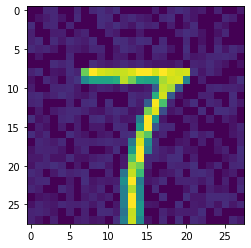

In [13]:
print(c)
plt.figure()
plt.imshow(tf.reshape(b, (28,28)))
plt.show()

In [16]:
np.count_nonzero(x-tf.reshape(a, (28*28,)))

503

In [17]:
model(a)

<tf.Tensor: shape=(1, 10), dtype=float32, numpy=
array([[0.        , 0.        , 0.00000004, 0.5007446 , 0.        ,
        0.        , 0.        , 0.49925447, 0.00000097, 0.        ]],
      dtype=float32)>

# Überbleibsel

In [ ]:

def unroll(tensor, shape):
    return tf.transpose(tf.reshape(tensor, shape))

def roll_back(tensor, shape):
    return(tf.reshape(tf.transpose(tensor), shape))


shape=(50176,3)
y = unroll(x, shape)
print(y.shape)
shape=(224,224,3)
z = roll_back(y, shape)
print(z.shape)


plt.figure()
plt.imshow(z)
plt.show()

In [ ]:
input_tensor = tf.Variable(initial_value=[[[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[-2., 2., 2.],
        [-2., 2., 2.],
        [-2., 2., 2.]],

       [[3., 1., 3.],
        [3., 3., 3.],
        [3., 3., 3.]]])
input_tensor*tf.Variable(initial_value=tf.zeros((3,3,3)))

In [ ]:
testmin = tf.math.reduce_sum(tf.math.abs(input_tensor), 0);testmin

In [ ]:
tf.math.argmin(testmin,1)

In [ ]:
#x = tf.convert_to_tensor(tf.expand_dims(x_train[1], axis=0), tf.float32)
def find_adv_example_l2(x, model, max_iterations=1000, mask= tf.Variable(initial_value=tf.ones(x.shape)), verbose=True):
    #x_in_attack_space = np.arctanh(1.999999999*x-1)
    #w = tf.Variable(initial_value=x_in_attack_space)
    w = tf.Variable(initial_value=tf.zeros(x.shape))
    #print('in l2 ',mask)
    #print(modifier)
    #show_adv = []
    optimizer = tf.keras.optimizers.Adam(.01)
    target = find_second_most_probable_class(get_logits(model,x))
    #target = 1
    l2_distance = []
    delta = []
    adv_image = []
    loss = []
    grads = []
    for i in range(max_iterations):
        if verbose: print(i)
        
        with tf.GradientTape() as tape:
            delta_now = ((.5 * (tf.tanh(w) + 1)) - x) * mask
            delta.append(delta_now)
            adv_image.append(x + delta)
            success = np.argmax(model(adv_image[i])) == target
            print(np.argmax(model(adv_image[i])), target, success)
            const= 1
            loss.append(loss_function(x=x, adv_image=adv_image[i], const=const, target=target))
            print(loss[i])
            #old_l2_distance = l2_distance
            l2_distance.append(tf.norm(adv_image[i] - x).numpy())
            
            
            grads.append(tape.gradient(loss[i], w))
            #print('loss:',loss)
            #print('w', w)
            #old_w = w
            optimizer.apply_gradients([(grads[i], w)])
            #w_hist.append(w)
            
            if i%10 == 0 and verbose:
                print('l2 dist:', l2_distance)
                print('l1 dist:', l1_distance)
                print('l_inf dist:', linf_distance)
                print('target class: ',target)
                print('pred of adv ex: ',np.argmax(model(adv_image)))
            if i>2 and l2_distance[i] > l2_distance[i-3] and success == True:
                grads = grads[i-3]
                delta = delta[i-3]
                adv_image = adv_image[i-3]
                w = w[i-3]
                return success, adv_image, grads, delta, w    
    return success, adv_image[i], grads[i], delta[i], w[i]
